## - 1 — Imports, settings, output paths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
DATA_PATHS = {
    "EN<->ES": "final_en_es_2.csv",
    "EN<->IT": "final_en_it_2.csv",
    "EN<->PT": "final_en_pt_2.csv",
}

SIDES_TO_RUN = ["src", "tgt"]
MODELS_TO_RUN = ["ridge", "lasso"]

RANDOM_STATE = 42

TEST_SIZE = 0.15
VAL_SIZE = 0.15

INNER_FOLDS = 5
ALPHAS = np.logspace(-3, 3, 25)
LASSO_MAX_ITER = 20000

USE_LOG1P_TARGET = True
HEATMAP_TOPN_FIELDS = 15

OUT_DIR = Path("rq2_baseline_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

results_store = []


## 2 — Feature lists

In [3]:
def monodirectional_feature_lists(side: str):
    side = side.lower().strip()
    if side not in {"src", "tgt"}:
        raise ValueError("side must be 'src' or 'tgt'.")

    num = [
        f"{side}_lemma_length",
        f"{side}_lexeme_count",
        f"{side}_session_count",
        "frequency",
        "concreteness",
    ]
    cat = [
        f"{side}_pos",
        "semantic_field",
    ]
    return num, cat


## 3 — Preprocessing + model pipeline

In [4]:
def make_preprocessor(numeric_features, categorical_features):
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([("scaler", StandardScaler())]), numeric_features),
            ("cat", Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_features),
        ],
        remainder="drop"
    )

def make_pipeline(model_name: str, numeric_features, categorical_features):
    name = model_name.lower().strip()
    if name == "ridge":
        model = Ridge(random_state=RANDOM_STATE)
    elif name == "lasso":
        model = Lasso(random_state=RANDOM_STATE, max_iter=LASSO_MAX_ITER)
    else:
        raise ValueError("model_name must be 'ridge' or 'lasso'.")

    pre = make_preprocessor(numeric_features, categorical_features)
    return Pipeline([("pre", pre), ("model", model)])


## 4 — Splits, metrics, tuning and executor

In [5]:
def make_splits(df: pd.DataFrame, target_col: str):
    df = df.dropna(subset=[target_col]).copy()

    df_tv, df_test = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
    )
    val_frac_of_tv = VAL_SIZE / (1.0 - TEST_SIZE)
    df_train, df_val = train_test_split(
        df_tv, test_size=val_frac_of_tv, random_state=RANDOM_STATE, shuffle=True
    )
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


def compute_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "mae": mae, "r2": r2}


def tune_alpha_on_train(X_train, y_train, model_name, num_feats, cat_feats):
    pipe = make_pipeline(model_name, num_feats, cat_feats)

    inner = KFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    search = GridSearchCV(
        estimator=pipe,
        param_grid={"model__alpha": ALPHAS},
        scoring="neg_root_mean_squared_error",
        cv=inner,
        n_jobs=-1,
        return_train_score=True,
        verbose=0,
    )
    search.fit(X_train, y_train)

    cvres = pd.DataFrame(search.cv_results_).copy()
    cvres["alpha"] = cvres["param_model__alpha"].astype(float)
    cvres["train_rmse_cv"] = -cvres["mean_train_score"]
    cvres["val_rmse_cv"] = -cvres["mean_test_score"]
    cvres["val_rmse_cv_std"] = cvres["std_test_score"]
    cvres = cvres.sort_values("alpha").reset_index(drop=True)

    best_alpha = float(search.best_params_["model__alpha"])
    return best_alpha, cvres


def run_one(df: pd.DataFrame, pair_label: str, side: str, model_name: str):
    side = side.lower().strip()
    model_name = model_name.lower().strip()

    target_col = f"{side}_median_hf_days"
    num_feats, cat_feats = monodirectional_feature_lists(side)

    df_train, df_val, df_test = make_splits(df, target_col=target_col)

    def get_y(dfx):
        y = pd.to_numeric(dfx[target_col], errors="coerce").to_numpy()
        return np.log1p(y) if USE_LOG1P_TARGET else y

    X_train = df_train[num_feats + cat_feats].copy()
    y_train = get_y(df_train)

    X_val = df_val[num_feats + cat_feats].copy()
    y_val = get_y(df_val)

    X_test = df_test[num_feats + cat_feats].copy()
    y_test = get_y(df_test)

    best_alpha, tune_df = tune_alpha_on_train(X_train, y_train, model_name, num_feats, cat_feats)

    pipe = make_pipeline(model_name, num_feats, cat_feats)
    pipe.set_params(**{"model__alpha": best_alpha})

    pipe.fit(X_train, y_train)
    yhat_train = pipe.predict(X_train)
    yhat_val = pipe.predict(X_val)

    train_metrics = compute_metrics(y_train, yhat_train)
    val_metrics = compute_metrics(y_val, yhat_val)

    X_trainval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
    y_trainval = np.concatenate([y_train, y_val], axis=0)

    pipe.fit(X_trainval, y_trainval)
    yhat_test = pipe.predict(X_test)
    test_metrics = compute_metrics(y_test, yhat_test)

    print("\n" + "=" * 98)
    print(f"[{pair_label}] BASELINE — {model_name.upper()} — task=predict_{side}")
    print(f"Target: {'log1p(' + target_col + ')' if USE_LOG1P_TARGET else target_col}")
    print(f"Split sizes  Train/Val/Test: {len(df_train)}/{len(df_val)}/{len(df_test)}")
    print(f"Best alpha (CV on Train): {best_alpha:g}")
    print("-" * 98)
    print("Train metrics:")
    print(f"  RMSE: {train_metrics['rmse']:.6f} | MAE: {train_metrics['mae']:.6f} | R^2: {train_metrics['r2']:.6f}")
    print("Val metrics:")
    print(f"  RMSE: {val_metrics['rmse']:.6f} | MAE: {val_metrics['mae']:.6f} | R^2: {val_metrics['r2']:.6f}")
    print("Test metrics:")
    print(f"  RMSE: {test_metrics['rmse']:.6f} | MAE: {test_metrics['mae']:.6f} | R^2: {test_metrics['r2']:.6f}")
    print("=" * 98)

    return {
        "pair": pair_label,
        "task": f"predict_{side}",
        "side": side,
        "model": model_name,
        "best_alpha": best_alpha,
        "train_rmse": train_metrics["rmse"],
        "train_mae": train_metrics["mae"],
        "train_r2": train_metrics["r2"],
        "val_rmse": val_metrics["rmse"],
        "val_mae": val_metrics["mae"],
        "val_r2": val_metrics["r2"],
        "test_rmse": test_metrics["rmse"],
        "test_mae": test_metrics["mae"],
        "test_r2": test_metrics["r2"],
        "tune_df": tune_df,
        "df_test": df_test.copy(),
        "y_test": y_test,
        "y_pred_test": yhat_test,
    }


## 5 — Plot functions

In [6]:
def plot_tuning_curve(tune_df: pd.DataFrame, title: str):
    df = tune_df.sort_values("alpha")
    plt.figure()
    plt.plot(df["alpha"], df["train_rmse_cv"], marker="o", label="Train RMSE (CV mean)")
    plt.plot(df["alpha"], df["val_rmse_cv"], marker="o", label="Val RMSE (CV mean)")
    plt.xscale("log")
    plt.xlabel("alpha (log scale)")
    plt.ylabel("RMSE (log space)" if USE_LOG1P_TARGET else "RMSE")
    plt.title(title)
    plt.legend()
    plt.tight_layout()


def plot_pred_vs_true(y_true, y_pred, title: str):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    mn = float(min(y_true.min(), y_pred.min()))
    mx = float(max(y_true.max(), y_pred.max()))
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()


def plot_residual_hist(y_true, y_pred, title: str):
    resid = y_true - y_pred
    plt.figure()
    plt.hist(resid, bins=30)
    plt.xlabel("Residual (true - pred)")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()


def plot_residual_vs_pred(y_true, y_pred, title: str):
    resid = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residual (true - pred)")
    plt.title(title)
    plt.tight_layout()


def plot_error_heatmap(df_test: pd.DataFrame, side: str, y_true, y_pred, title: str, topn_fields=15):
    pos_col = f"{side}_pos"
    field_col = "semantic_field"

    abs_err = np.abs(y_true - y_pred)
    tmp = df_test[[pos_col, field_col]].copy()
    tmp["abs_error"] = abs_err

    top_fields = tmp[field_col].value_counts().head(topn_fields).index.tolist()
    tmp = tmp[tmp[field_col].isin(top_fields)].copy()

    pivot = tmp.pivot_table(index=field_col, columns=pos_col, values="abs_error", aggfunc="mean")
    pivot = pivot.sort_index()

    plt.figure(figsize=(10, 6))
    plt.imshow(pivot.to_numpy(), aspect="auto")
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.colorbar(label="Mean |error| (log space)")
    plt.title(title)
    plt.tight_layout()


## 6 — EN↔ES

In [7]:
pair_label = "EN<->ES"
df_es = pd.read_csv(DATA_PATHS[pair_label])

for side in SIDES_TO_RUN:
    for model_name in MODELS_TO_RUN:
        res = run_one(df_es, pair_label=pair_label, side=side, model_name=model_name)
        results_store.append(res)

print(f"\nStored results so far: {len(results_store)} runs")



[EN<->ES] BASELINE — RIDGE — task=predict_src
Target: log1p(src_median_hf_days)
Split sizes  Train/Val/Test: 924/199/199
Best alpha (CV on Train): 1000
--------------------------------------------------------------------------------------------------
Train metrics:
  RMSE: 1.909407 | MAE: 1.526458 | R^2: 0.096235
Val metrics:
  RMSE: 1.914239 | MAE: 1.538212 | R^2: 0.129422
Test metrics:
  RMSE: 1.959949 | MAE: 1.475219 | R^2: 0.067271

[EN<->ES] BASELINE — LASSO — task=predict_src
Target: log1p(src_median_hf_days)
Split sizes  Train/Val/Test: 924/199/199
Best alpha (CV on Train): 0.01
--------------------------------------------------------------------------------------------------
Train metrics:
  RMSE: 1.739528 | MAE: 1.325815 | R^2: 0.249896
Val metrics:
  RMSE: 1.733211 | MAE: 1.328761 | R^2: 0.286296
Test metrics:
  RMSE: 1.805435 | MAE: 1.311151 | R^2: 0.208539

[EN<->ES] BASELINE — RIDGE — task=predict_tgt
Target: log1p(tgt_median_hf_days)
Split sizes  Train/Val/Test: 924/199/

## 7 — EN↔IT

In [8]:
pair_label = "EN<->IT"
df_it = pd.read_csv(DATA_PATHS[pair_label])

for side in SIDES_TO_RUN:
    for model_name in MODELS_TO_RUN:
        res = run_one(df_it, pair_label=pair_label, side=side, model_name=model_name)
        results_store.append(res)

print(f"\nStored results so far: {len(results_store)} runs")



[EN<->IT] BASELINE — RIDGE — task=predict_src
Target: log1p(src_median_hf_days)
Split sizes  Train/Val/Test: 667/144/144
Best alpha (CV on Train): 17.7828
--------------------------------------------------------------------------------------------------
Train metrics:
  RMSE: 1.815079 | MAE: 1.375525 | R^2: 0.187555
Val metrics:
  RMSE: 1.872560 | MAE: 1.411041 | R^2: 0.126971
Test metrics:
  RMSE: 1.989146 | MAE: 1.493690 | R^2: 0.110135

[EN<->IT] BASELINE — LASSO — task=predict_src
Target: log1p(src_median_hf_days)
Split sizes  Train/Val/Test: 667/144/144
Best alpha (CV on Train): 0.0177828
--------------------------------------------------------------------------------------------------
Train metrics:
  RMSE: 1.842974 | MAE: 1.407034 | R^2: 0.162392
Val metrics:
  RMSE: 1.903038 | MAE: 1.443665 | R^2: 0.098321
Test metrics:
  RMSE: 1.988974 | MAE: 1.494705 | R^2: 0.110289

[EN<->IT] BASELINE — RIDGE — task=predict_tgt
Target: log1p(tgt_median_hf_days)
Split sizes  Train/Val/Test: 

## 8 — EN↔PT

In [9]:
pair_label = "EN<->PT"
df_pt = pd.read_csv(DATA_PATHS[pair_label])

for side in SIDES_TO_RUN:
    for model_name in MODELS_TO_RUN:
        res = run_one(df_pt, pair_label=pair_label, side=side, model_name=model_name)
        results_store.append(res)

print(f"\nStored results so far: {len(results_store)} runs")



[EN<->PT] BASELINE — RIDGE — task=predict_src
Target: log1p(src_median_hf_days)
Split sizes  Train/Val/Test: 796/171/171
Best alpha (CV on Train): 5.62341
--------------------------------------------------------------------------------------------------
Train metrics:
  RMSE: 1.866228 | MAE: 1.519413 | R^2: 0.260449
Val metrics:
  RMSE: 1.743041 | MAE: 1.390104 | R^2: 0.327026
Test metrics:
  RMSE: 1.944859 | MAE: 1.520155 | R^2: 0.180836

[EN<->PT] BASELINE — LASSO — task=predict_src
Target: log1p(src_median_hf_days)
Split sizes  Train/Val/Test: 796/171/171
Best alpha (CV on Train): 0.00562341
--------------------------------------------------------------------------------------------------
Train metrics:
  RMSE: 1.872217 | MAE: 1.522095 | R^2: 0.255695
Val metrics:
  RMSE: 1.739949 | MAE: 1.384727 | R^2: 0.329412
Test metrics:
  RMSE: 1.935271 | MAE: 1.517600 | R^2: 0.188893

[EN<->PT] BASELINE — RIDGE — task=predict_tgt
Target: log1p(tgt_median_hf_days)
Split sizes  Train/Val/Test:

## 9 — Summary table

In [10]:
summary_df = pd.DataFrame([{
    "pair": r["pair"],
    "task": r["task"],
    "model": r["model"],
    "best_alpha": r["best_alpha"],
    "train_rmse": r["train_rmse"],
    "val_rmse": r["val_rmse"],
    "test_rmse": r["test_rmse"],
    "train_mae": r["train_mae"],
    "val_mae": r["val_mae"],
    "test_mae": r["test_mae"],
    "train_r2": r["train_r2"],
    "val_r2": r["val_r2"],
    "test_r2": r["test_r2"],
} for r in results_store]).sort_values(["pair", "task", "model"]).reset_index(drop=True)

summary_path = OUT_DIR / "baseline_train_val_test_summary.csv"
summary_df.to_csv(summary_path, index=False)

print(f"Saved summary CSV: {summary_path}")
summary_df


Saved summary CSV: rq2_baseline_outputs\baseline_train_val_test_summary.csv


,pair,task,model,best_alpha,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae,train_r2,val_r2,test_r2
0,EN<->ES,predict_src,lasso,0.010000,1.739528,1.733211,1.805435,1.325815,1.328761,1.311151,0.249896,0.286296,0.208539
1,EN<->ES,predict_src,ridge,1000.000000,1.909407,1.914239,1.959949,1.526458,1.538212,1.475219,0.096235,0.129422,0.067271
2,EN<->ES,predict_tgt,lasso,0.005623,1.439245,1.352973,1.269235,0.973338,0.876615,0.863920,0.182987,0.179642,0.145652
3,EN<->ES,predict_tgt,ridge,10.000000,1.429783,1.347411,1.259335,0.970968,0.874881,0.855267,0.193693,0.186373,0.158928
4,EN<->IT,predict_src,lasso,0.017783,1.842974,1.903038,1.988974,1.407034,1.443665,1.494705,0.162392,0.098321,0.110289
5,EN<->IT,predict_src,ridge,17.782794,1.815079,1.872560,1.989146,1.375525,1.411041,1.493690,0.187555,0.126971,0.110135
6,EN<->IT,predict_tgt,lasso,0.010000,2.008073,1.986708,1.980505,1.556444,1.537028,1.591053,0.144393,0.133215,0.134045
7,EN<->IT,predict_tgt,ridge,10.000000,2.007260,2.006645,1.985782,1.567434,1.566796,1.591423,0.145086,0.115732,0.129425
8,EN<->PT,predict_src,lasso,0.005623,1.872217,1.739949,1.935271,1.522095,1.384727,1.517600,0.255695,0.329412,0.188893
9,EN<->PT,predict_src,ridge,5.623413,1.866228,1.743041,1.944859,1.519413,1.390104,1.520155,0.260449,0.327026,0.180836


## 10 — Export PDFs per plot type

In [11]:
ridge_runs = [r for r in results_store if r["model"] == "ridge"]
lasso_runs = [r for r in results_store if r["model"] == "lasso"]

pdf_tune_ridge = OUT_DIR / "tuning_curves_RIDGE.pdf"
pdf_tune_lasso = OUT_DIR / "tuning_curves_LASSO.pdf"
pdf_pred_true = OUT_DIR / "pred_vs_true_TEST.pdf"
pdf_resid_hist = OUT_DIR / "residual_hist_TEST.pdf"
pdf_resid_vs_pred = OUT_DIR / "residual_vs_pred_TEST.pdf"
pdf_heatmaps = OUT_DIR / "error_heatmaps_TEST.pdf"

with PdfPages(pdf_tune_ridge) as pdf:
    for r in ridge_runs:
        title = f"{r['pair']} | {r['task']} | RIDGE | best_alpha={r['best_alpha']:g}"
        plot_tuning_curve(r["tune_df"], title=title)
        pdf.savefig()
        plt.close()

with PdfPages(pdf_tune_lasso) as pdf:
    for r in lasso_runs:
        title = f"{r['pair']} | {r['task']} | LASSO | best_alpha={r['best_alpha']:g}"
        plot_tuning_curve(r["tune_df"], title=title)
        pdf.savefig()
        plt.close()

with PdfPages(pdf_pred_true) as pdf:
    for r in results_store:
        title = f"{r['pair']} | {r['task']} | {r['model'].upper()} | Test pred vs true"
        plot_pred_vs_true(r["y_test"], r["y_pred_test"], title=title)
        pdf.savefig()
        plt.close()

with PdfPages(pdf_resid_hist) as pdf:
    for r in results_store:
        title = f"{r['pair']} | {r['task']} | {r['model'].upper()} | Test residual distribution"
        plot_residual_hist(r["y_test"], r["y_pred_test"], title=title)
        pdf.savefig()
        plt.close()

with PdfPages(pdf_resid_vs_pred) as pdf:
    for r in results_store:
        title = f"{r['pair']} | {r['task']} | {r['model'].upper()} | Test residuals vs predicted"
        plot_residual_vs_pred(r["y_test"], r["y_pred_test"], title=title)
        pdf.savefig()
        plt.close()

with PdfPages(pdf_heatmaps) as pdf:
    for r in results_store:
        title = f"{r['pair']} | {r['task']} | {r['model'].upper()} | Test mean |error| heatmap"
        plot_error_heatmap(
            df_test=r["df_test"],
            side=r["side"],
            y_true=r["y_test"],
            y_pred=r["y_pred_test"],
            title=title,
            topn_fields=HEATMAP_TOPN_FIELDS
        )
        pdf.savefig()
        plt.close()

print("Saved plot bundles:")
print(f" - {pdf_tune_ridge}")
print(f" - {pdf_tune_lasso}")
print(f" - {pdf_pred_true}")
print(f" - {pdf_resid_hist}")
print(f" - {pdf_resid_vs_pred}")
print(f" - {pdf_heatmaps}")


Saved plot bundles:
 - rq2_baseline_outputs\tuning_curves_RIDGE.pdf
 - rq2_baseline_outputs\tuning_curves_LASSO.pdf
 - rq2_baseline_outputs\pred_vs_true_TEST.pdf
 - rq2_baseline_outputs\residual_hist_TEST.pdf
 - rq2_baseline_outputs\residual_vs_pred_TEST.pdf
 - rq2_baseline_outputs\error_heatmaps_TEST.pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _require_cols(df, cols, name="df"):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} is missing columns: {missing}")


REQ_SUMMARY = ["pair", "task", "model", "test_rmse", "test_r2"]


In [4]:
METRIC = "test_rmse"   
MODEL  = "ridge"       

summary_df = pd.read_csv("rq2_baseline_outputs/baseline_train_val_test_summary.csv")


_require_cols(summary_df, REQ_SUMMARY, name="summary_df")

plot_df = summary_df.copy()
plot_df["direction"] = plot_df["task"].map({"predict_src": "src", "predict_tgt": "tgt"})

plot_df = plot_df[plot_df["model"].str.lower() == MODEL].copy()
plot_df = plot_df[plot_df["direction"].isin(["src", "tgt"])].copy()

_require_cols(plot_df, ["pair", "direction", METRIC], name="plot_df")
plot_df


,pair,task,model,best_alpha,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae,train_r2,val_r2,test_r2,direction
1,EN<->ES,predict_src,ridge,1000.000000,1.909407,1.914239,1.959949,1.526458,1.538212,1.475219,0.096235,0.129422,0.067271,src
3,EN<->ES,predict_tgt,ridge,10.000000,1.429783,1.347411,1.259335,0.970968,0.874881,0.855267,0.193693,0.186373,0.158928,tgt
5,EN<->IT,predict_src,ridge,17.782794,1.815079,1.872560,1.989146,1.375525,1.411041,1.493690,0.187555,0.126971,0.110135,src
7,EN<->IT,predict_tgt,ridge,10.000000,2.007260,2.006645,1.985782,1.567434,1.566796,1.591423,0.145086,0.115732,0.129425,tgt
9,EN<->PT,predict_src,ridge,5.623413,1.866228,1.743041,1.944859,1.519413,1.390104,1.520155,0.260449,0.327026,0.180836,src
11,EN<->PT,predict_tgt,ridge,17.782794,2.343096,2.537442,2.158823,1.822329,1.964437,1.739266,0.108855,0.065563,0.101487,tgt


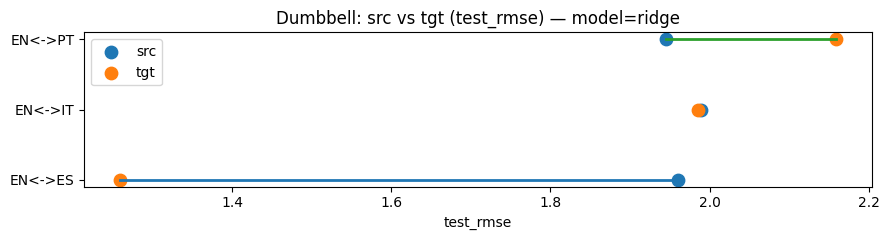

In [5]:
def dumbbell_plot(df, metric, title=None):
    # df must have: pair, direction in {src,tgt}, metric
    wide = df.pivot_table(index="pair", columns="direction", values=metric, aggfunc="mean")
    wide = wide.dropna(subset=["src", "tgt"]).sort_index()

    pairs = wide.index.tolist()
    y = np.arange(len(pairs))

    src = wide["src"].values
    tgt = wide["tgt"].values

    plt.figure(figsize=(9, max(2.5, 0.6*len(pairs))))
    for i in range(len(pairs)):
        plt.plot([src[i], tgt[i]], [y[i], y[i]], linewidth=2)

    plt.scatter(src, y, label="src", s=80)
    plt.scatter(tgt, y, label="tgt", s=80)

    plt.yticks(y, pairs)
    plt.xlabel(metric)
    plt.title(title or f"Dumbbell: src vs tgt ({metric}) — model={MODEL}")
    plt.legend()
    plt.tight_layout()

dumbbell_plot(plot_df, METRIC)
plt.show()


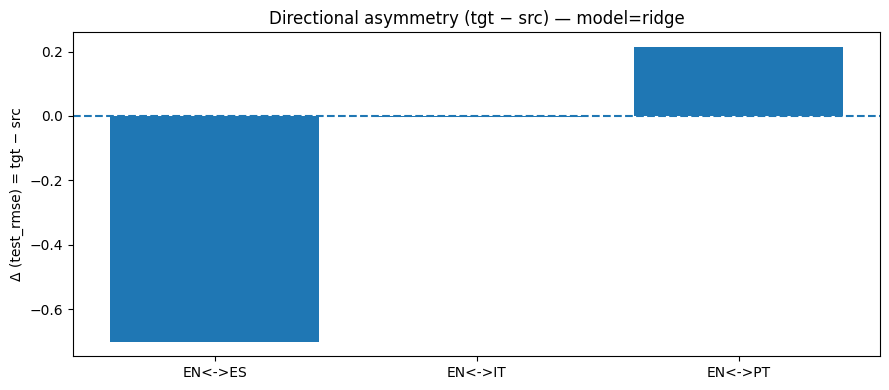

direction,src,tgt,delta_tgt_minus_src
pair,,,
EN<->ES,1.959949,1.259335,-0.700614
EN<->IT,1.989146,1.985782,-0.003364
EN<->PT,1.944859,2.158823,0.213963


In [6]:
def delta_bar_plot(df, metric, title=None):
    wide = df.pivot_table(index="pair", columns="direction", values=metric, aggfunc="mean")
    wide = wide.dropna(subset=["src", "tgt"]).sort_index()
    wide["delta_tgt_minus_src"] = wide["tgt"] - wide["src"]

    plt.figure(figsize=(9, 4))
    plt.bar(wide.index, wide["delta_tgt_minus_src"].values)
    plt.axhline(0, linestyle="--")
    plt.ylabel(f"Δ ({metric}) = tgt − src")
    plt.title(title or f"Directional asymmetry (tgt − src) — model={MODEL}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    return wide[["src","tgt","delta_tgt_minus_src"]]

delta_table = delta_bar_plot(plot_df, METRIC)
plt.show()
delta_table


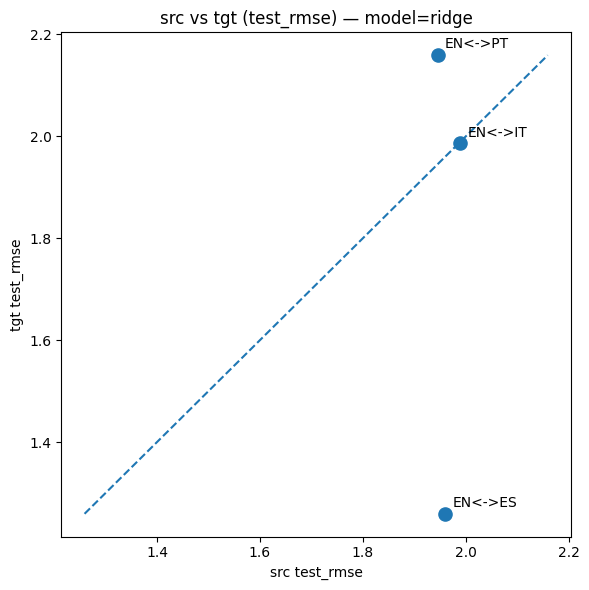

In [ ]:
def src_vs_tgt_scatter(df, metric, title=None):
    wide = df.pivot_table(index="pair", columns="direction", values=metric, aggfunc="mean")
    wide = wide.dropna(subset=["src", "tgt"]).sort_index()

    x = wide["src"].values
    y = wide["tgt"].values

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, s=90)

    
    mn = float(min(x.min(), y.min()))
    mx = float(max(x.max(), y.max()))
    plt.plot([mn, mx], [mn, mx], linestyle="--")

    for pair in wide.index:
        plt.annotate(pair, (wide.loc[pair,"src"], wide.loc[pair,"tgt"]), xytext=(5,5), textcoords="offset points")

    plt.xlabel(f"src {metric}")
    plt.ylabel(f"tgt {metric}")
    plt.title(title or f"src vs tgt ({metric}) — model={MODEL}")
    plt.tight_layout()

src_vs_tgt_scatter(plot_df, METRIC)
plt.show()


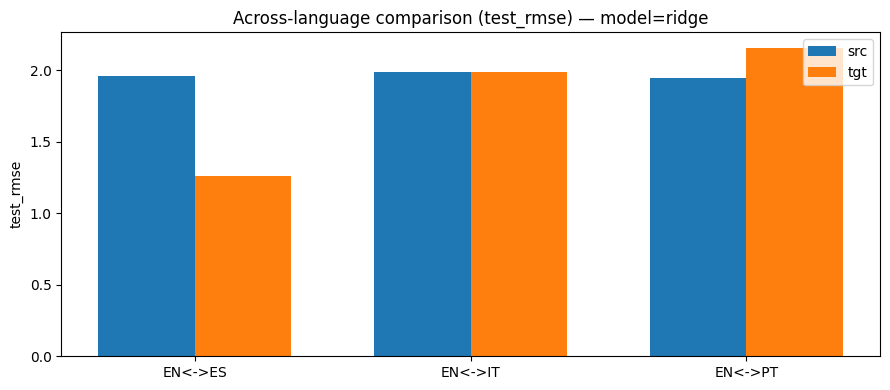

In [9]:
def grouped_bar_pairs(df, metric, title=None):
    wide = df.pivot_table(index="pair", columns="direction", values=metric, aggfunc="mean").sort_index()
    pairs = wide.index.tolist()

    x = np.arange(len(pairs))
    width = 0.35

    plt.figure(figsize=(9,4))
    plt.bar(x - width/2, wide["src"].values, width, label="src")
    plt.bar(x + width/2, wide["tgt"].values, width, label="tgt")

    plt.xticks(x, pairs)
    plt.ylabel(metric)
    plt.title(title or f"Across-language comparison ({metric}) — model={MODEL}")
    plt.legend()
    plt.tight_layout()

grouped_bar_pairs(plot_df, METRIC)
plt.show()


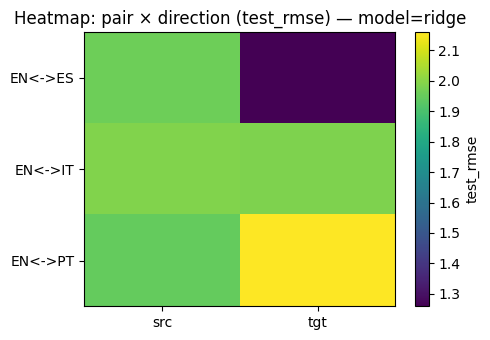

In [10]:
def heatmap_pair_direction(df, metric, title=None):
    wide = df.pivot_table(index="pair", columns="direction", values=metric, aggfunc="mean").sort_index()
    mat = wide[["src","tgt"]].to_numpy()

    plt.figure(figsize=(5, 3.5))
    plt.imshow(mat, aspect="auto")
    plt.yticks(np.arange(len(wide.index)), wide.index)
    plt.xticks([0,1], ["src","tgt"])
    plt.colorbar(label=metric)
    plt.title(title or f"Heatmap: pair × direction ({metric}) — model={MODEL}")
    plt.tight_layout()

heatmap_pair_direction(plot_df, METRIC)
plt.show()


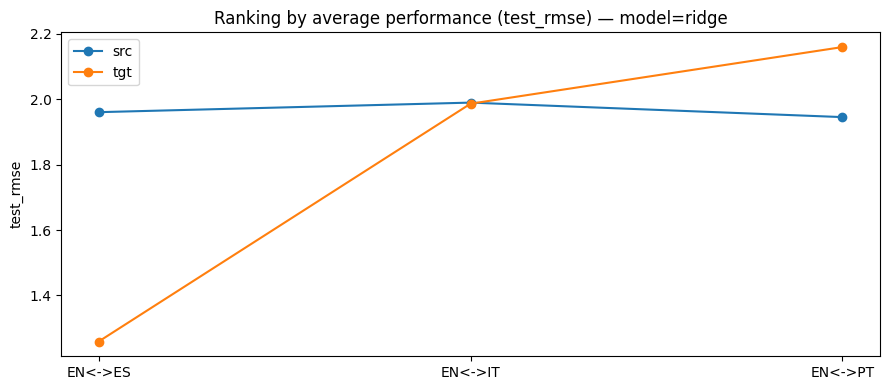

In [11]:
def ranking_plot(df, metric, title=None):
    wide = df.pivot_table(index="pair", columns="direction", values=metric, aggfunc="mean")
    wide["avg"] = wide[["src","tgt"]].mean(axis=1)
    wide = wide.sort_values("avg")

    plt.figure(figsize=(9,4))
    plt.plot(wide.index, wide["src"], marker="o", label="src")
    plt.plot(wide.index, wide["tgt"], marker="o", label="tgt")
    plt.xticks(rotation=0)
    plt.ylabel(metric)
    plt.title(title or f"Ranking by average performance ({metric}) — model={MODEL}")
    plt.legend()
    plt.tight_layout()

ranking_plot(plot_df, METRIC)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15

def make_splits_with_ids(df: pd.DataFrame, target_col: str):
    df = df.dropna(subset=[target_col]).copy()

    
    df = df.reset_index(drop=False).rename(columns={"index": "row_id"})

    df_tv, df_test = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
    )
    val_frac_of_tv = VAL_SIZE / (1.0 - TEST_SIZE)
    df_train, df_val = train_test_split(
        df_tv, test_size=val_frac_of_tv, random_state=RANDOM_STATE, shuffle=True
    )

    return df_train, df_val, df_test


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split


RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15

DATA_PATHS = {
    "EN<->ES": "final_en_es_2.csv",
    "EN<->IT": "final_en_it_2.csv",
    "EN<->PT": "final_en_pt_2.csv",
}

SIDES = ["src", "tgt"]


def make_splits_with_ids(df: pd.DataFrame, target_col: str):
    df = df.dropna(subset=[target_col]).copy()

    
    df = df.reset_index(drop=False).rename(columns={"index": "row_id"})

    df_tv, df_test = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        shuffle=True,
    )

    val_frac_of_tv = VAL_SIZE / (1.0 - TEST_SIZE)

    df_train, df_val = train_test_split(
        df_tv,
        test_size=val_frac_of_tv,
        random_state=RANDOM_STATE,
        shuffle=True,
    )

    return df_train, df_val, df_test


splits_store = {}

for pair, path in DATA_PATHS.items():
    df = pd.read_csv(path)

    for side in SIDES:
        target_col = f"{side}_median_hf_days"

        df_train, df_val, df_test = make_splits_with_ids(df, target_col)

        splits_store[(pair, side)] = {
            "train": df_train,
            "val": df_val,
            "test": df_test,
        }

        print(f"\n{pair} | predict_{side}")
        print(f"  train: {len(df_train):4d}  val: {len(df_val):4d}  test: {len(df_test):4d}")
        print(f"  example test row_ids: {df_test['row_id'].head().tolist()}")



EN<->ES | predict_src
  train:  924  val:  199  test:  199
  example test row_ids: [727, 479, 240, 422, 49]

EN<->ES | predict_tgt
  train:  924  val:  199  test:  199
  example test row_ids: [727, 479, 240, 422, 49]

EN<->IT | predict_src
  train:  667  val:  144  test:  144
  example test row_ids: [199, 422, 695, 752, 388]

EN<->IT | predict_tgt
  train:  667  val:  144  test:  144
  example test row_ids: [199, 422, 695, 752, 388]

EN<->PT | predict_src
  train:  796  val:  171  test:  171
  example test row_ids: [788, 904, 289, 1040, 332]

EN<->PT | predict_tgt
  train:  796  val:  171  test:  171
  example test row_ids: [788, 904, 289, 1040, 332]


In [10]:
import json
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor


BASE_SUMMARY_PATH = Path("rq2_baseline_outputs/baseline_train_val_test_summary.csv")
XGB_SUMMARY_PATH  = Path("rq2_xgb_cross_outputs/summary_xgb_cross_repeated_nested_cv.csv")
XGB_PARAMS_DIR = Path("rq2_xgb_cross_outputs")


base_sum = pd.read_csv(BASE_SUMMARY_PATH)
best_base = base_sum.loc[base_sum.groupby(["pair","task"])["test_rmse"].idxmin()].copy()
best_base = best_base.set_index(["pair","task"])


TARGET_COLS = ["src_median_hf_days", "tgt_median_hf_days"]


def make_preprocessor_from_df(df: pd.DataFrame, scale_numeric: bool = True):
    cat_cols = [c for c in df.columns if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
    num_cols = [c for c in df.columns if c not in cat_cols]

    num_pipe = Pipeline([("scaler", StandardScaler())]) if scale_numeric else "passthrough"
    cat_pipe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3,
    )


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def eval_metrics(y_true, y_pred):
    return {
        "rmse": rmse(y_true, y_pred),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2":  float(r2_score(y_true, y_pred)),
    }


def load_xgb_params(pair: str, side: str):
    safe_pair = pair.replace("<->", "_").replace("↔", "_")
    candidates = [
        XGB_PARAMS_DIR / f"best_params_{safe_pair}_predict_{side}.json",
        XGB_PARAMS_DIR / f"best_params_{safe_pair}_{side}.json",
    ]
    for p in candidates:
        if p.exists():
            with open(p, "r", encoding="utf-8") as f:
                obj = json.load(f)
            if isinstance(obj, dict) and "best_params" in obj:
                obj = obj["best_params"]
            if isinstance(obj, list):
                obj = obj[0]
            if isinstance(obj, dict):
                return obj
            raise TypeError(f"Invalid XGB params format in {p}")
    return {
        "max_depth": 6,
        "min_child_weight": 1.0,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "gamma": 0.0,
        "reg_alpha": 0.0,
        "reg_lambda": 1.0,
    }


SCALE_NUMERIC = True
USE_LOG1P_TARGET = True

eval_rows = []
pred_rows = []

for (pair, side), split in splits_store.items():
    task = f"predict_{side}"
    target_col = f"{side}_median_hf_days"

    df_train = split["train"].copy()
    df_val   = split["val"].copy()
    df_test  = split["test"].copy()

    feature_cols = [c for c in df_train.columns if c not in TARGET_COLS]

    X_train = df_train[feature_cols].copy()
    X_val   = df_val[feature_cols].copy()
    X_test  = df_test[feature_cols].copy()

    y_train = df_train[target_col].to_numpy()
    y_val   = df_val[target_col].to_numpy()
    y_test  = df_test[target_col].to_numpy()

    if USE_LOG1P_TARGET:
        y_train = np.log1p(y_train)
        y_val   = np.log1p(y_val)
        y_test  = np.log1p(y_test)

    test_row_id = df_test["row_id"].to_numpy()

    for X in (X_train, X_val, X_test):
        if "row_id" in X.columns:
            X.drop(columns=["row_id"], inplace=True)

    nan_cols = pd.concat([X_train, X_val], axis=0).columns[
        pd.concat([X_train, X_val], axis=0).isna().any()
    ].tolist()

    if len(nan_cols) > 0:
        X_train = X_train.drop(columns=nan_cols)
        X_val   = X_val.drop(columns=nan_cols)
        X_test  = X_test.drop(columns=nan_cols)

    pre = make_preprocessor_from_df(X_train, scale_numeric=SCALE_NUMERIC)

    base_info = best_base.loc[(pair, task)]
    base_model_name = str(base_info["model"]).lower()
    base_alpha = float(base_info["best_alpha"])

    if base_model_name == "ridge":
        base_est = Ridge(alpha=base_alpha, random_state=42)
    else:
        base_est = Lasso(alpha=base_alpha, max_iter=20000, random_state=42)

    base_pipe = Pipeline([("pre", pre), ("model", base_est)])
    base_pipe.fit(
        pd.concat([X_train, X_val], axis=0),
        np.concatenate([y_train, y_val], axis=0),
    )
    yhat_base = base_pipe.predict(X_test)
    base_m = eval_metrics(y_test, yhat_base)

    xgb_params = load_xgb_params(pair, side)
    n_estimators_default = 600

    try:
        xgb = XGBRegressor(
            **{k: v for k, v in xgb_params.items() if k != "n_estimators"},
            n_estimators=n_estimators_default,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
            eval_metric="rmse",
            early_stopping_rounds=50,
        )

        Xtr = pre.fit_transform(X_train)
        Xva = pre.transform(X_val)
        Xte = pre.transform(X_test)

        xgb.fit(Xtr, y_train, eval_set=[(Xva, y_val)], verbose=False)
        yhat_xgb = xgb.predict(Xte)

        best_iter = getattr(xgb, "best_iteration", None)
        effective_n = int(best_iter) + 1 if best_iter is not None else n_estimators_default

    except Exception:
        xgb = XGBRegressor(
            **{k: v for k, v in xgb_params.items() if k != "n_estimators"},
            n_estimators=300,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
        )

        Xtr = pre.fit_transform(X_train)
        Xte = pre.transform(X_test)
        xgb.fit(Xtr, y_train, verbose=False)
        yhat_xgb = xgb.predict(Xte)
        effective_n = 300

    xgb_m = eval_metrics(y_test, yhat_xgb)

    eval_rows.append({
        "pair": pair,
        "task": task,
        "baseline_model": base_model_name,
        "baseline_alpha": base_alpha,
        "baseline_rmse": base_m["rmse"],
        "baseline_mae": base_m["mae"],
        "baseline_r2":  base_m["r2"],
        "xgb_rmse": xgb_m["rmse"],
        "xgb_mae": xgb_m["mae"],
        "xgb_r2":  xgb_m["r2"],
        "rmse_gain": base_m["rmse"] - xgb_m["rmse"],
        "r2_gain":   xgb_m["r2"] - base_m["r2"],
        "xgb_effective_n_estimators": effective_n,
        "dropped_nan_cols": ",".join(nan_cols) if len(nan_cols) else "",
    })

    for rid, yt, pb, px in zip(test_row_id, y_test, yhat_base, yhat_xgb):
        pred_rows.append({
            "pair": pair,
            "task": task,
            "row_id": int(rid),
            "y_true": float(yt),
            "y_pred_base": float(pb),
            "y_pred_xgb": float(px),
            "err_base": float(pb - yt),
            "err_xgb": float(px - yt),
            "abs_err_base": float(abs(pb - yt)),
            "abs_err_xgb": float(abs(px - yt)),
            "abs_err_improvement": float(abs(pb - yt) - abs(px - yt)),
        })

eval_df = pd.DataFrame(eval_rows).sort_values(["pair","task"]).reset_index(drop=True)
pred_df = pd.DataFrame(pred_rows)

display(eval_df)
print("\nMean RMSE gain (baseline − XGB):", eval_df["rmse_gain"].mean())
print("Tasks where XGB is better (rmse_gain>0):", int((eval_df["rmse_gain"] > 0).sum()), "/", len(eval_df))


C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\xgboost\callback.py:386: UserWarning: [13:01:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "best_params", "best_value_inner_rmse", "outer_fold", "pair", "repeat", "task" } are not used.

  self.starting_round = model.num_boosted_rounds()
C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\xgboost\callback.py:386: UserWarning: [13:01:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "best_params", "best_value_inner_rmse", "outer_fold", "pair", "repeat", "task" } are not used.

  self.starting_round = model.num_boosted_rounds()
C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\xgboost\callback.py:386: UserWarning: [13:01:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "best_params", "best_value_inner_rmse", "outer_fold", "pair", "repeat", "task" } are not used.

  self.starting_round = m

,pair,task,baseline_model,baseline_alpha,baseline_rmse,baseline_mae,baseline_r2,xgb_rmse,xgb_mae,xgb_r2,rmse_gain,r2_gain,xgb_effective_n_estimators,dropped_nan_cols
0,EN<->ES,predict_src,lasso,0.010000,1.800538,1.307502,0.212826,1.245433,0.896395,0.623377,0.555104,0.410551,162,src_median_hf
1,EN<->ES,predict_tgt,ridge,10.000000,1.193502,0.801186,0.244566,0.554188,0.158025,0.837121,0.639314,0.592556,7,src_median_hf
2,EN<->IT,predict_src,lasso,0.017783,1.627001,1.255439,0.404658,0.086348,0.039531,0.998323,1.540653,0.593665,14,
3,EN<->IT,predict_tgt,lasso,0.010000,1.891201,1.527555,0.210379,1.617437,1.169630,0.422439,0.273764,0.212060,148,
4,EN<->PT,predict_src,lasso,0.005623,1.620445,1.297324,0.431326,0.060622,0.030600,0.999204,1.559823,0.567878,212,
5,EN<->PT,predict_tgt,lasso,0.010000,2.129179,1.686560,0.125993,2.028590,1.495657,0.206624,0.100589,0.080631,99,



Mean RMSE gain (baseline − XGB): 0.7782079227676424
Tasks where XGB is better (rmse_gain>0): 6 / 6


In [11]:
from pathlib import Path

OUT_ALIGN = Path("rq2_aligned_test_outputs")
OUT_ALIGN.mkdir(parents=True, exist_ok=True)

eval_path = OUT_ALIGN / "aligned_eval_baseline_vs_xgb.csv"
pred_path = OUT_ALIGN / "aligned_pred_baseline_vs_xgb.csv"

eval_df.to_csv(eval_path, index=False)
pred_df.to_csv(pred_path, index=False)

print("Saved:")
print(" -", eval_path)
print(" -", pred_path)


Saved:
 - rq2_aligned_test_outputs\aligned_eval_baseline_vs_xgb.csv
 - rq2_aligned_test_outputs\aligned_pred_baseline_vs_xgb.csv


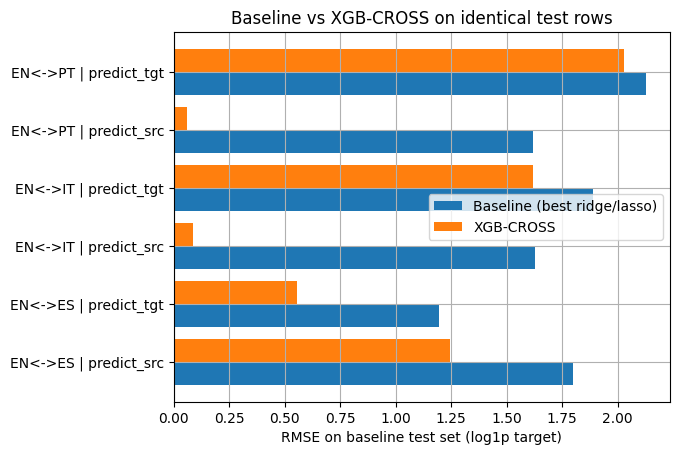

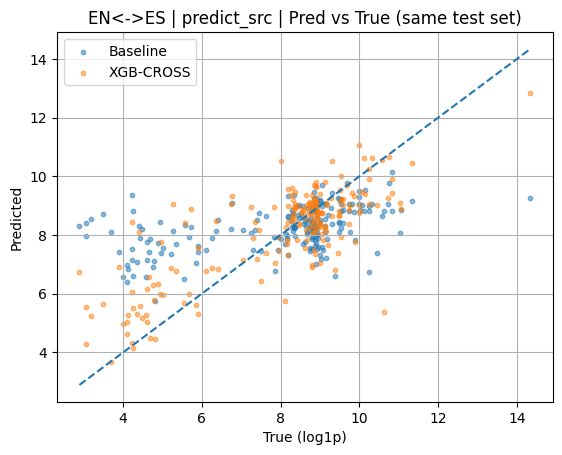

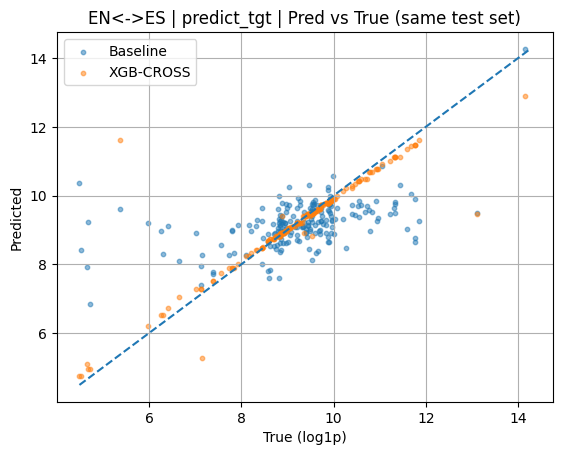

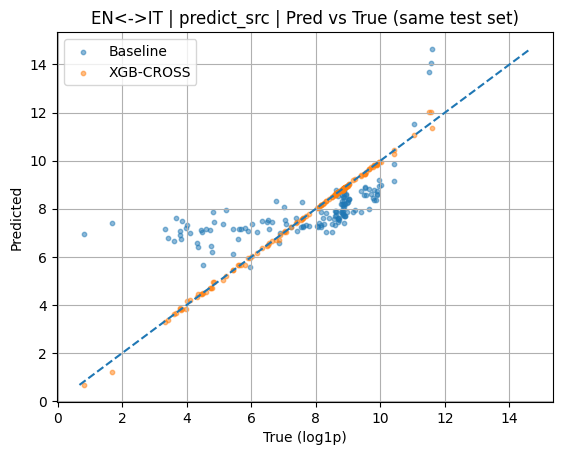

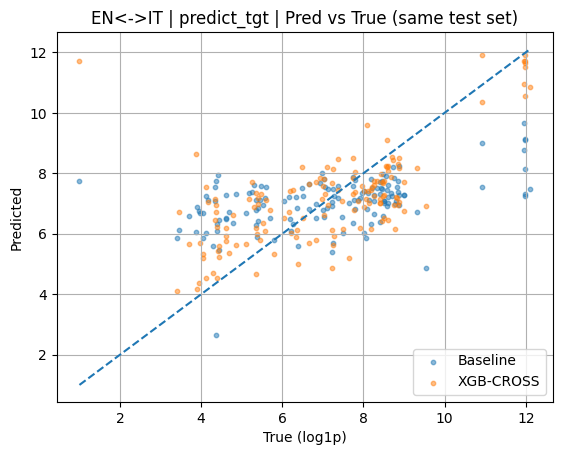

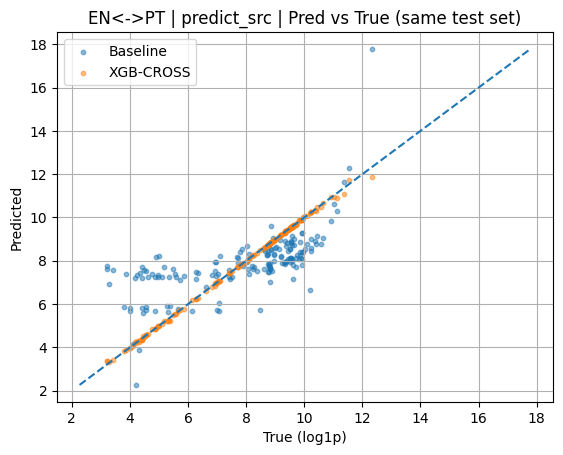

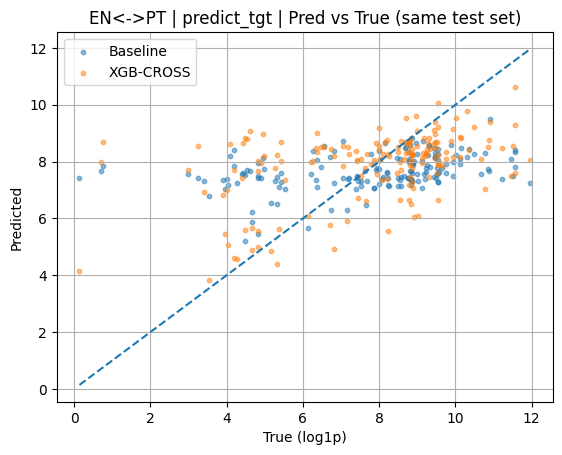

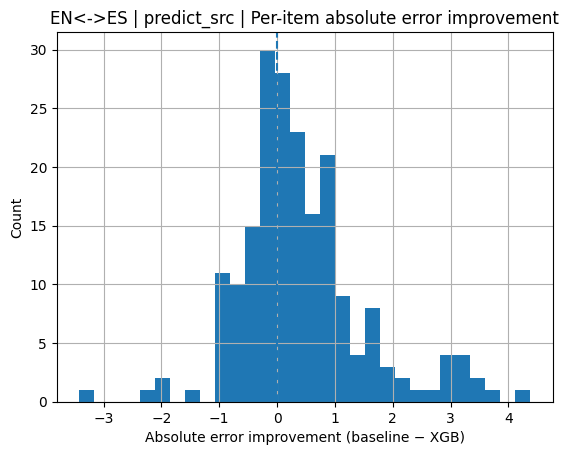

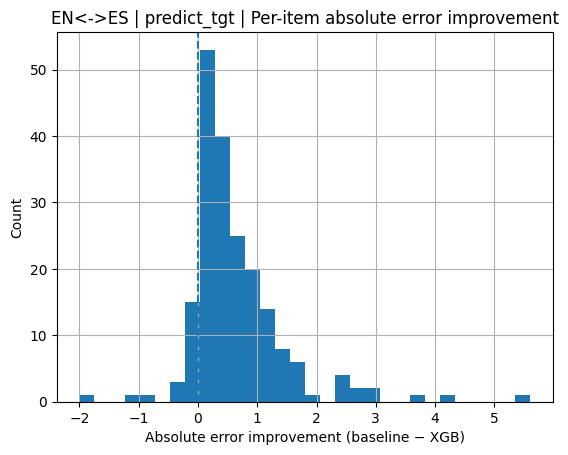

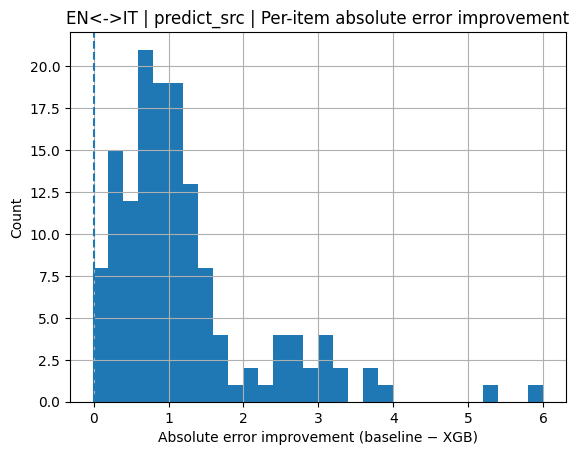

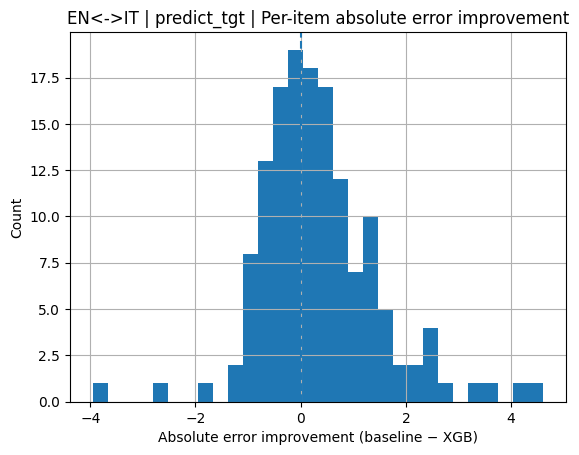

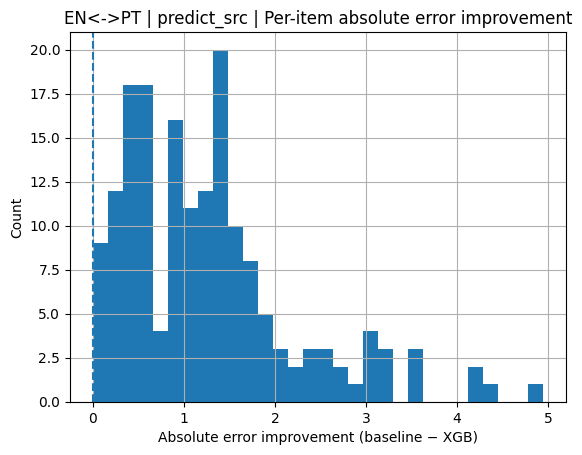

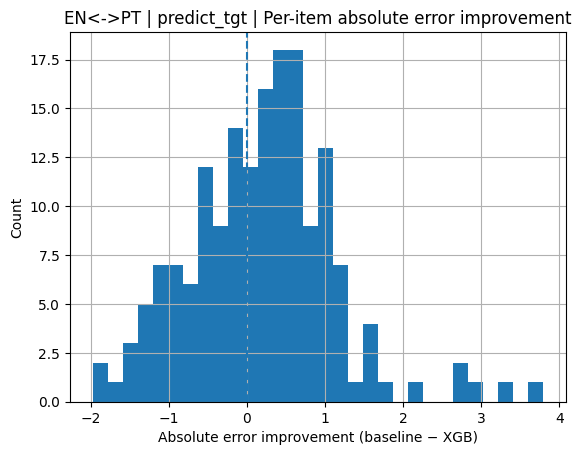

C:\Users\paolo\AppData\Local\Temp\ipykernel_22260\3038143550.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: (d["abs_err_improvement"] > 0).mean())


,pair,task,xgb_item_win_rate
0,EN<->ES,predict_src,0.608040
1,EN<->ES,predict_tgt,0.914573
2,EN<->IT,predict_src,0.986111
3,EN<->IT,predict_tgt,0.597222
4,EN<->PT,predict_src,0.994152
5,EN<->PT,predict_tgt,0.590643


In [12]:
import matplotlib.pyplot as plt
import numpy as np


labels = (eval_df["pair"] + " | " + eval_df["task"]).tolist()
y_base = eval_df["baseline_rmse"].to_numpy()
y_xgb  = eval_df["xgb_rmse"].to_numpy()

plt.figure()
y_pos = np.arange(len(labels))
plt.barh(y_pos - 0.2, y_base, height=0.4, label="Baseline (best ridge/lasso)")
plt.barh(y_pos + 0.2, y_xgb,  height=0.4, label="XGB-CROSS")
plt.yticks(y_pos, labels)
plt.xlabel("RMSE on baseline test set (log1p target)")
plt.title("Baseline vs XGB-CROSS on identical test rows")
plt.legend()
plt.grid(True)
plt.show()


for (pair, task), df_g in pred_df.groupby(["pair","task"]):
    plt.figure()
    plt.scatter(df_g["y_true"], df_g["y_pred_base"], s=10, alpha=0.5, label="Baseline")
    plt.scatter(df_g["y_true"], df_g["y_pred_xgb"],  s=10, alpha=0.5, label="XGB-CROSS")
    mn = min(df_g["y_true"].min(), df_g["y_pred_base"].min(), df_g["y_pred_xgb"].min())
    mx = max(df_g["y_true"].max(), df_g["y_pred_base"].max(), df_g["y_pred_xgb"].max())
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("True (log1p)")
    plt.ylabel("Predicted")
    plt.title(f"{pair} | {task} | Pred vs True (same test set)")
    plt.legend()
    plt.grid(True)
    plt.show()


for (pair, task), df_g in pred_df.groupby(["pair","task"]):
    plt.figure()
    plt.hist(df_g["abs_err_improvement"], bins=30)
    plt.axvline(0, linestyle="--")
    plt.xlabel("Absolute error improvement (baseline − XGB)")
    plt.ylabel("Count")
    plt.title(f"{pair} | {task} | Per-item absolute error improvement")
    plt.grid(True)
    plt.show()


win_rates = (
    pred_df.groupby(["pair","task"])
           .apply(lambda d: (d["abs_err_improvement"] > 0).mean())
           .reset_index(name="xgb_item_win_rate")
)
display(win_rates)
